In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import matplotlib.pyplot as plt
import itertools
import random

In [2]:
# Import transformers package from huggingface
%%capture
!pip install transformers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel

In [4]:
# Import Bio_ClinicalBERT model from huggingface
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



### Input data from existing CSV


In [5]:
from google.colab import drive 
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [32]:
## Read data in
df = pd.read_csv('drive/My Drive/Team USA/dataset_corrected.csv')

In [33]:
df.iloc[629811]

Unnamed: 0    629811                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
Title         Multimodal system 

In [34]:
# Create citation graph
Citations_Graph = df['Citations'].dropna().to_dict()
Citations_Graph.items()

Output hidden; open in https://colab.research.google.com to view.

In [35]:
# "explode" graph into tuples of x cites y
citations = [(key, int(value)) for key, values in Citations_Graph.items() for value in values.split(',')]

train_df = df.loc[:int(0.90*df.shape[0]),:]
test_df = df.loc[int(0.90*df.shape[0])+1:,:]
len_train = len(train_df)
len_test = len(test_df)

train_citations_graph = train_df['Citations'].dropna().to_dict()
test_citations_graph = test_df['Citations'].dropna().to_dict()

train_citations = [(key, int(value)) for key, values in train_citations_graph.items() for value in values.split(',') if int(value) < len_train]
test_citations = [(key, int(value)) for key, values in test_citations_graph.items() for value in values.split(',') if int(value) > len_train]

venues = [(df['Venue'][c[0]], df['Venue'][c[1]]) for c in citations]
venues = [v for v in venues if (type(v[1])==str and type(v[0])==str)]

print(f"{len(venues)} entries in venues")

536459 entries in venues


In [36]:
train_venues = [(df['Venue'][c[0]], df['Venue'][c[1]]) for c in train_citations]
train_venues = [v for v in train_venues if (type(v[1])==str and type(v[0])==str)]

test_venues = [(df['Venue'][c[0]], df['Venue'][c[1]]) for c in test_citations]
test_venues = [v for v in test_venues if (type(v[1])==str and type(v[0])==str)]

In [37]:
# Code to create a dictionary 
# will help to know what venue a certain venue does NOT cite
# use this further in random venue generation for negative samples
d = {}
for v1, v2 in venues:
    if v1 not in d:
        d[v1] = []
    else:
        if v2 not in d[v1]:
            d[v1].append(v2)

# random.choice(list(d.items()))

In [38]:
import random

class Venues(Dataset):

  def __init__(self,venues):
    super().__init__()
    
    self.venues = venues
    self.venue_mapping()

  def __len__(self):

    return len(self.venues)

  def venue_mapping(self):
    d = {}
    for v1, v2 in self.venues:
      if v1 not in d:
        d[v1] = []
      else:
        if v2 not in d[v1]:
          d[v1].append(v2)
    self.d = d

  def __getitem__(self,index):

    X = []
    X.append(self.venues[index][0])
    X.append(self.venues[index][0])
   

    Y = []
    Y.append(self.venues[index][1])

    rand_venue = self.venues[random.randint(0, len(self.venues)-1)][1]
    while rand_venue in self.d[self.venues[index][0]]:
      rand_venue = self.venues[random.randint(0, len(self.venues)-1)][1]

    Y.append(rand_venue)

    labels = [1,0]
  
    return X,Y,labels

In [39]:
# train_venues = venues[:int(0.9*len(venues))]
# test_venues = venues[int(0.9*len(venues))+1:]

train_dataset = Venues(train_venues)
test_dataset = Venues(test_venues)

In [40]:
len(test_dataset.venues)
len(train_dataset.venues)

433074

In [41]:
train_dataset[2000], test_dataset[2000]

((['IEEE/ACM Transactions on Networking (TON)',
   'IEEE/ACM Transactions on Networking (TON)'],
  ['Proceedings of the joint international conference on Measurement and modeling of computer systems',
   'Prentice-Hall Object-Oriented Series'],
  [1, 0]),
 (['ACM Transactions on Mathematical Software (TOMS)',
   'ACM Transactions on Mathematical Software (TOMS)'],
  ['ACM Transactions on Mathematical Software (TOMS)',
   'International Journal of Human-Computer Studies'],
  [1, 0]))

In [42]:
def custom_collate(batch):

  # batch is list of samples : batch = [dataset[0],dataset[1], and so on...]

  # lists to store titles and labels
  venue1 = []
  venue2 = []
  labels = []

  for sample in batch:

    # print(sample)

    venue1.append(sample[0][0])
    venue1.append(sample[0][1])
    venue2.append(sample[1][0])
    venue2.append(sample[1][1])
    labels.extend(sample[2])

  return {"venue1": np.array(venue1),"venue2": np.array(venue2), "labels":labels}

In [43]:
df.isnull().sum()/len(df)

Unnamed: 0    0.000000
Title         0.000000
Authors       0.041149
Year          0.000000
Venue         0.156545
Abstract      0.553710
Citations     0.800938
dtype: float64

In [44]:
class VenueBERT(nn.Module):

  def __init__(self):
    super().__init__()

    self.bertVenue = AutoModel.from_pretrained('allenai/scibert_scivocab_cased')
    self.linear = nn.Linear(768,1)

  def forward(self,inputs):

    outs = self.bertVenue(**inputs)
    outs = torch.mean(outs['last_hidden_state'],dim = 1)
    outs = self.linear(outs)
    outs = torch.sigmoid(outs)

    return outs

In [45]:
BATCH_SIZE = 128
trainloader = DataLoader(train_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = False)
testloader = DataLoader(test_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = False)

In [46]:
device = torch.device("cuda")

In [55]:
NUM_EPOCHS = 1

venuemodel = VenueBERT()
venuemodel.to(device)
criterion = nn.BCELoss()

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
for name,param in venuemodel.named_parameters():
    param.requires_grad = False

venuemodel.bertVenue.encoder.layer[11].attention.self.query.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.self.query.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.self.key.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.self.key.bias.requires_grad= True
venuemodel.bertVenue.encoder.layer[11].attention.self.value.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.self.value.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.output.dense.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.output.dense.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.output.LayerNorm.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].attention.output.LayerNorm.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].intermediate.dense.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].intermediate.dense.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].output.dense.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].output.dense.bias.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].output.LayerNorm.weight.requires_grad = True
venuemodel.bertVenue.encoder.layer[11].output.LayerNorm.bias.requires_grad = True
venuemodel.linear.weight.requires_grad = True
venuemodel.linear.bias.requires_grad = True

for name,param in venuemodel.named_parameters():
  if (param.requires_grad == True):
    print(name)

bertVenue.encoder.layer.11.attention.self.query.weight
bertVenue.encoder.layer.11.attention.self.query.bias
bertVenue.encoder.layer.11.attention.self.key.weight
bertVenue.encoder.layer.11.attention.self.key.bias
bertVenue.encoder.layer.11.attention.self.value.weight
bertVenue.encoder.layer.11.attention.self.value.bias
bertVenue.encoder.layer.11.attention.output.dense.weight
bertVenue.encoder.layer.11.attention.output.dense.bias
bertVenue.encoder.layer.11.attention.output.LayerNorm.weight
bertVenue.encoder.layer.11.attention.output.LayerNorm.bias
bertVenue.encoder.layer.11.intermediate.dense.weight
bertVenue.encoder.layer.11.intermediate.dense.bias
bertVenue.encoder.layer.11.output.dense.weight
bertVenue.encoder.layer.11.output.dense.bias
bertVenue.encoder.layer.11.output.LayerNorm.weight
bertVenue.encoder.layer.11.output.LayerNorm.bias
linear.weight
linear.bias


In [57]:
from transformers import AdamW
optim = AdamW(venuemodel.parameters(), lr = 1e-3)

loss_list = []

for epoch in range(NUM_EPOCHS):
    
    venuemodel.train()
    
    for batch_idx, batch in enumerate(trainloader):
        
      optim.zero_grad()

      # print(batch)

      inputs = tokenizer(list(batch['venue1']),list(batch['venue2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
    #   print(inputs)
      output = venuemodel(inputs.to(device))
      
      loss = criterion(output.to(device),torch.tensor(np.array(batch['labels']).reshape(-1,1)).to(torch.float32).to(device))
    #   print(loss)

      loss_list.append(loss)
      
      loss.backward()

      # if not batch_idx % 50:

      print(f"epoch number = {epoch}", f"batch {batch_idx}/{len(trainloader)}", f"loss = {round(loss.item(),2)}")

      optim.step()
            
    

#     model.eval()
#     with torch.set_grad_enabled(False):
#         print(f'training accuracy: '
#               f'{compute_accuracy(model, trainloader, device):.2f}%'
#               f'\nvalid accuracy: '
#               f'{compute_accuracy(model, validloader, device):.2f}%')
        
#     print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
# print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
# print(f'Test accuracy: {compute_accuracy(model, testloader, device):.2f}%')
# 

epoch number = 0 batch 0/3384 loss = 0.69
epoch number = 0 batch 1/3384 loss = 1.63
epoch number = 0 batch 2/3384 loss = 0.84
epoch number = 0 batch 3/3384 loss = 0.88
epoch number = 0 batch 4/3384 loss = 0.66
epoch number = 0 batch 5/3384 loss = 0.87
epoch number = 0 batch 6/3384 loss = 0.7
epoch number = 0 batch 7/3384 loss = 0.64
epoch number = 0 batch 8/3384 loss = 0.71
epoch number = 0 batch 9/3384 loss = 0.7
epoch number = 0 batch 10/3384 loss = 0.66
epoch number = 0 batch 11/3384 loss = 0.67
epoch number = 0 batch 12/3384 loss = 0.68
epoch number = 0 batch 13/3384 loss = 0.65
epoch number = 0 batch 14/3384 loss = 0.63
epoch number = 0 batch 15/3384 loss = 0.63
epoch number = 0 batch 16/3384 loss = 0.59
epoch number = 0 batch 17/3384 loss = 0.55
epoch number = 0 batch 18/3384 loss = 0.6


KeyboardInterrupt: ignored

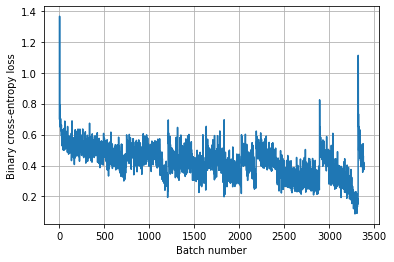

In [30]:
# plot the loss curve

def plot_loss_curve(loss, filename):

  plt.plot(loss)
  plt.ylabel("Binary cross-entropy loss")
  plt.xlabel("Batch number")
  plt.grid(True)
  plt.savefig(filename)
  plt.show()

plot_loss_curve(loss_list, 'drive/My Drive/Team USA/plots/venue_128.png')



In [ ]:
plt.savefig('')

In [ ]:
torch.save(venuemodel,'drive/My Drive/Team USA/models/modelvenue_run_2_full.pth')

In [59]:
venuebert = torch.load('drive/My Drive/Team USA/models/venuemodel_kaggle_pat.pth')
# venuebert = torch.load('drive/My Drive/Team USA/models/modelvenue_run_2_full.pth')
venuebert.to(device)

VenueBERT(
  (bertVenue): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [60]:
def compute_accuracy(model, data_loader, device):
    
    model.eval()

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            print(f"{batch_idx} of {len(data_loader)}")

            ### Prepare data
            inputs = tokenizer(list(batch['venue1']),list(batch['venue2']),return_tensors='pt',
                    max_length = 32,
                    truncation = True,
                    padding = 'max_length')
            
            labels = torch.Tensor(batch['labels']).view(-1,1).to(device)
            
            outputs = model(inputs.to(device))

            predicted_labels = torch.round(outputs)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()

            print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100

In [61]:
BATCH_SIZE = 256
trainloader = DataLoader(train_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = False)
compute_accuracy(venuemodel,trainloader,'cuda')

0 of 1692
tensor(68.5547, device='cuda:0')
1 of 1692
tensor(67.3828, device='cuda:0')
2 of 1692
tensor(68.2292, device='cuda:0')
3 of 1692
tensor(68.3594, device='cuda:0')
4 of 1692
tensor(68.0859, device='cuda:0')
5 of 1692
tensor(67.6432, device='cuda:0')
6 of 1692
tensor(67.6060, device='cuda:0')
7 of 1692
tensor(67.9932, device='cuda:0')
8 of 1692
tensor(68.2292, device='cuda:0')
9 of 1692
tensor(68.2031, device='cuda:0')
10 of 1692
tensor(67.9155, device='cuda:0')
11 of 1692
tensor(67.8385, device='cuda:0')
12 of 1692
tensor(67.5631, device='cuda:0')
13 of 1692
tensor(67.8432, device='cuda:0')
14 of 1692
tensor(68.1120, device='cuda:0')
15 of 1692


KeyboardInterrupt: ignored

In [62]:
BATCH_SIZE = 256
testloader = DataLoader(test_dataset, collate_fn = custom_collate, batch_size = BATCH_SIZE, shuffle = True)
compute_accuracy(venuemodel,testloader,'cuda')

0 of 25
tensor(60.9375, device='cuda:0')
1 of 25
tensor(60.8398, device='cuda:0')
2 of 25
tensor(60.2214, device='cuda:0')
3 of 25
tensor(59.9121, device='cuda:0')
4 of 25
tensor(60.2734, device='cuda:0')
5 of 25
tensor(60.0260, device='cuda:0')
6 of 25
tensor(59.9888, device='cuda:0')
7 of 25
tensor(60.1318, device='cuda:0')
8 of 25


KeyboardInterrupt: ignored